In [3]:
# load dataset

mobilize_file_path = '../data/Mobilisation_data.csv'
mobilize_info_file_path =  '../data/info_mobilize.csv'

incident_file_path = '../data/Incident_data.csv'
incident_info_file_path =  '../data/info_incident.csv'

mobilize = pd.read_csv(mobilize_file_path, low_memory=False)  #mobilization dataframe
incident = pd.read_csv(incident_file_path, low_memory=False)  # incident dataframe

# join the two dataframes and print analysis
merged_df = mobilize.merge(right=incident, on=["IncidentNumber", "HourOfCall", "CalYear"], how="inner")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce

%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [3]:
merged_df["DateOfCall"] = pd.to_datetime(merged_df["DateOfCall"]) # turn data type into datetime
merged_df["day"] = merged_df["DateOfCall"].dt.day # create column weekday
merged_df["weekday"] = merged_df["DateOfCall"].dt.weekday # create column weekday
merged_df["month"] = merged_df["DateOfCall"].dt.month # create column month

In [5]:
merged_df[merged_df.DelayCode_Description.isna() == True]['AttendanceTimeSeconds'].max()

1200

In [ ]:
#Stunde in Sin cos
#check resource code and deployed from station

In [ ]:
# Calculatiog the latitude and longitude from the easting and northing
import pyproj
from pyproj import Transformer
import time

# Initialize the transformer
transformer = Transformer.from_crs("epsg:27700", "epsg:4326")

df_coordinates = merged_df.copy()

start_time = time.time()

for index, row in df_coordinates.iterrows():
    lon, lat = transformer.transform(row['Easting_m'], row['Northing_m'])
    df_coordinates.at[index, 'Incident_Latitude'] = lat
    df_coordinates.at[index, 'Incident_Longitude'] = lon

end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

L_L_Stations = pd.read_csv('lfb-stations-jun2021.csv')

df_coordinates['DeployedFromStation_Name'] = df_coordinates['DeployedFromStation_Name'].str.lower()
L_L_Stations['Station_Name'] = L_L_Stations['Station_Name'].str.lower()

# Merge the dataframes
merged_df = pd.merge(df_coordinates, L_L_Stations, how='left', left_on='DeployedFromStation_Name', right_on='Station_Name')

from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convert all latitudes/longitudes from decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Calculate haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    R = 6371  # Radius of earth in kilometers
    return c * R

merged_df['TravelDistance'] = merged_df.apply(lambda row: haversine(row['Station_Latitude'], row['Station_Longitude'], row['Latitude'], row['Longitude']), axis=1)
display(merged_df)

In [4]:
# Remove unwanted values from the relationship between TurnoutTimeSeconds and AttendanceTimeSeconds
# Plotting before removing values
rr_df = merged_df[merged_df['PumpOrder'] == 1] # keep only PumpOrder 1
rr_df = rr_df[rr_df['AttendanceTimeSeconds'] >= 20] # only AttendanceTime over 10 seconds
rr_df = rr_df[rr_df['TravelTimeSeconds'] >= 10] # only TravelTime over 10 seconds
rr_df = rr_df[rr_df['TurnoutTimeSeconds'] >= 10] # only TurnoutTime over 10 seconds

rr_df['SpecialServiceType'].fillna('No Special Service', inplace=True) # fill the missing values of special service type with 'no special service'
rr_df = rr_df[~(rr_df['TurnoutTimeSeconds'] > rr_df['AttendanceTimeSeconds'])] # remove rows where attendanceTime is smaller than turnout time
rr_df = rr_df[rr_df['CalYear'] != 2020]
rr_df = rr_df[rr_df['CalYear'] > 2014]

rr_df['Easting_m'].fillna(rr_df['Easting_rounded'], inplace=True)
rr_df['Northing_m'].fillna(rr_df['Northing_rounded'], inplace=True)

In [5]:
rr_df['new'] = rr_df.apply(lambda x: 0 if x['IncidentStationGround'] == x['DeployedFromStation_Name'] else 1, axis=1)

In [7]:
columns_to_drop = ['UPRN', 'USRN','DateAndTimeMobile','IncGeo_BoroughCode','Resource_Code','PropertyType', 'Postcode_district', 'IncidentNumber', 'DateAndTimeMobilised',  'Easting_m','Northing_m','Latitude', 'DeployedFromStation_Code',
                   'Longitude','FRS','FirstPumpArriving_AttendanceTime','FirstPumpArriving_DeployedFromStation','IncGeo_WardName',
                   'NumStationsWithPumpsAttending','SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation',
                   'ResourceMobilisationId', 'IncGeo_BoroughName','DateAndTimeArrived','DateAndTimeLeft', 'DeployedFromStation_Name',
                   'DateAndTimeReturned',  'Notional Cost (£)', 'PumpHoursRoundUp','DelayCode_Description', 'SpecialServiceType',
                   'FirstPumpArriving_AttendanceTime', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'PumpCount', 'NumPumpsAttending',
                   'PlusCode_Description','PerformanceReporting', 'DateOfCall', 'TimeOfCall', 'PumpOrder',  'Postcode_full',
                   'DelayCodeId', 'ProperCase','IncGeo_WardNameNew', 'AddressQualifier','NumCalls', 'StopCodeDescription', 'IncidentStationGround',
                   'Resource_Code','PlusCode_Code' , 'IncGeo_WardCode','PropertyType','IncGeo_WardNameNew', 'IncidentGroup', 'PropertyCategory', 'DeployedFromLocation']

new = ['AddressQualifier', 'ProperCase', 'weekday' , 'month', 'HourOfCall', 'CalYear', '' ]

cleaned_df = rr_df.drop(columns=columns_to_drop) # drop the identified columns
cleaned_df.dropna(inplace=True) # drop rows with missing values

# turn flloats in intiger data type
#for column in cleaned_df.select_dtypes(include=['float']):
#    cleaned_df[column] = cleaned_df[column].astype('int')

#for column in cleaned_df.select_dtypes(exclude=np. number):
#    cleaned_df[column] = cleaned_df[column].astype('category')


# display missing values and data types for columns that are left in the dataframe - check no missing values?
display(pd.concat([cleaned_df.isnull().sum(), cleaned_df.dtypes, cleaned_df.nunique()], axis=1, keys=['Missing Values', 'Data Types', 'Number modalities']))
print('cleaned data shape:', cleaned_df.shape)


,Missing Values,Data Types,Number modalities
CalYear,0,int64,8
HourOfCall,0,int64,24
AttendanceTimeSeconds,0,int64,1181
Easting_rounded,0,int64,571
Northing_rounded,0,int64,443
day,0,int64,31
weekday,0,int64,7
month,0,int64,12
new,0,int64,2


cleaned data shape: (710950, 9)


# ab hier ausführen

In [6]:
processed_file_path = '../data/cleaned_df.csv'
cleaned_df = pd.read_csv(processed_file_path)
cleaned_df.head()

,Resource_Code,DeployedFromStation_Name,DeployedFromLocation,IncidentGroup,SpecialServiceType,PropertyCategory,Postcode_district,IncGeo_BoroughName,IncGeo_WardNameNew,IncidentStationGround,...,AttendanceTimeSeconds,UPRN,USRN,Station_Longitude,Station_Latitude,Incident_Longitude,Incident_Latitude,TravelDistance,StationLoc_same_IncidentLoc,TravelSpeed(km/h)
0,A352,enfield,Home Station,Fire,No Special Service,Outdoor,EN2,enfield,Whitewebbs,Enfield,...,404,207116635.0,20702538.0,-0.052311,51.660016,-0.083285,51.666162,2.242970,1,22.430
1,G251,ealing,Home Station,Fire,No Special Service,Outdoor,W7,ealing,North Hanwell,Ealing,...,299,12061941.0,20600908.0,-0.313797,51.511948,-0.335284,51.518135,1.638306,1,26.448
2,H291,purley,Home Station,Special Service,Flooding,Dwelling,CR8,croydon,Kenley,Purley,...,401,0.0,20500307.0,-0.124801,51.331843,-0.115196,51.316283,1.854438,0,43.921
3,A361,southgate,Home Station,Fire,No Special Service,Dwelling,EN2,enfield,Ridgeway,Enfield,...,362,0.0,20703006.0,-0.127323,51.630493,-0.098321,51.654131,3.303604,0,36.039
4,A342,edmonton,Home Station,Fire,No Special Service,Road Vehicle,EN2,enfield,Grange Park,Enfield,...,545,NaN,NaN,-0.068483,51.626818,-0.081256,51.649160,2.636024,0,20.765


In [9]:
cleaned_df.columns

Index(['Resource_Code', 'DeployedFromStation_Name', 'DeployedFromLocation',
       'IncidentGroup', 'SpecialServiceType', 'PropertyCategory',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardNameNew',
       'IncidentStationGround', 'day', 'weekday', 'month', 'CalYear',
       'HourOfCall', 'AttendanceTimeSeconds', 'UPRN', 'USRN',
       'Station_Longitude', 'Station_Latitude', 'Incident_Longitude',
       'Incident_Latitude', 'TravelDistance', 'StationLoc_same_IncidentLoc',
       'TravelSpeed(km/h)'],
      dtype='object')

C:\Users\User1\AppData\Local\Temp\ipykernel_9896\3057856280.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = cleaned_df.corr()


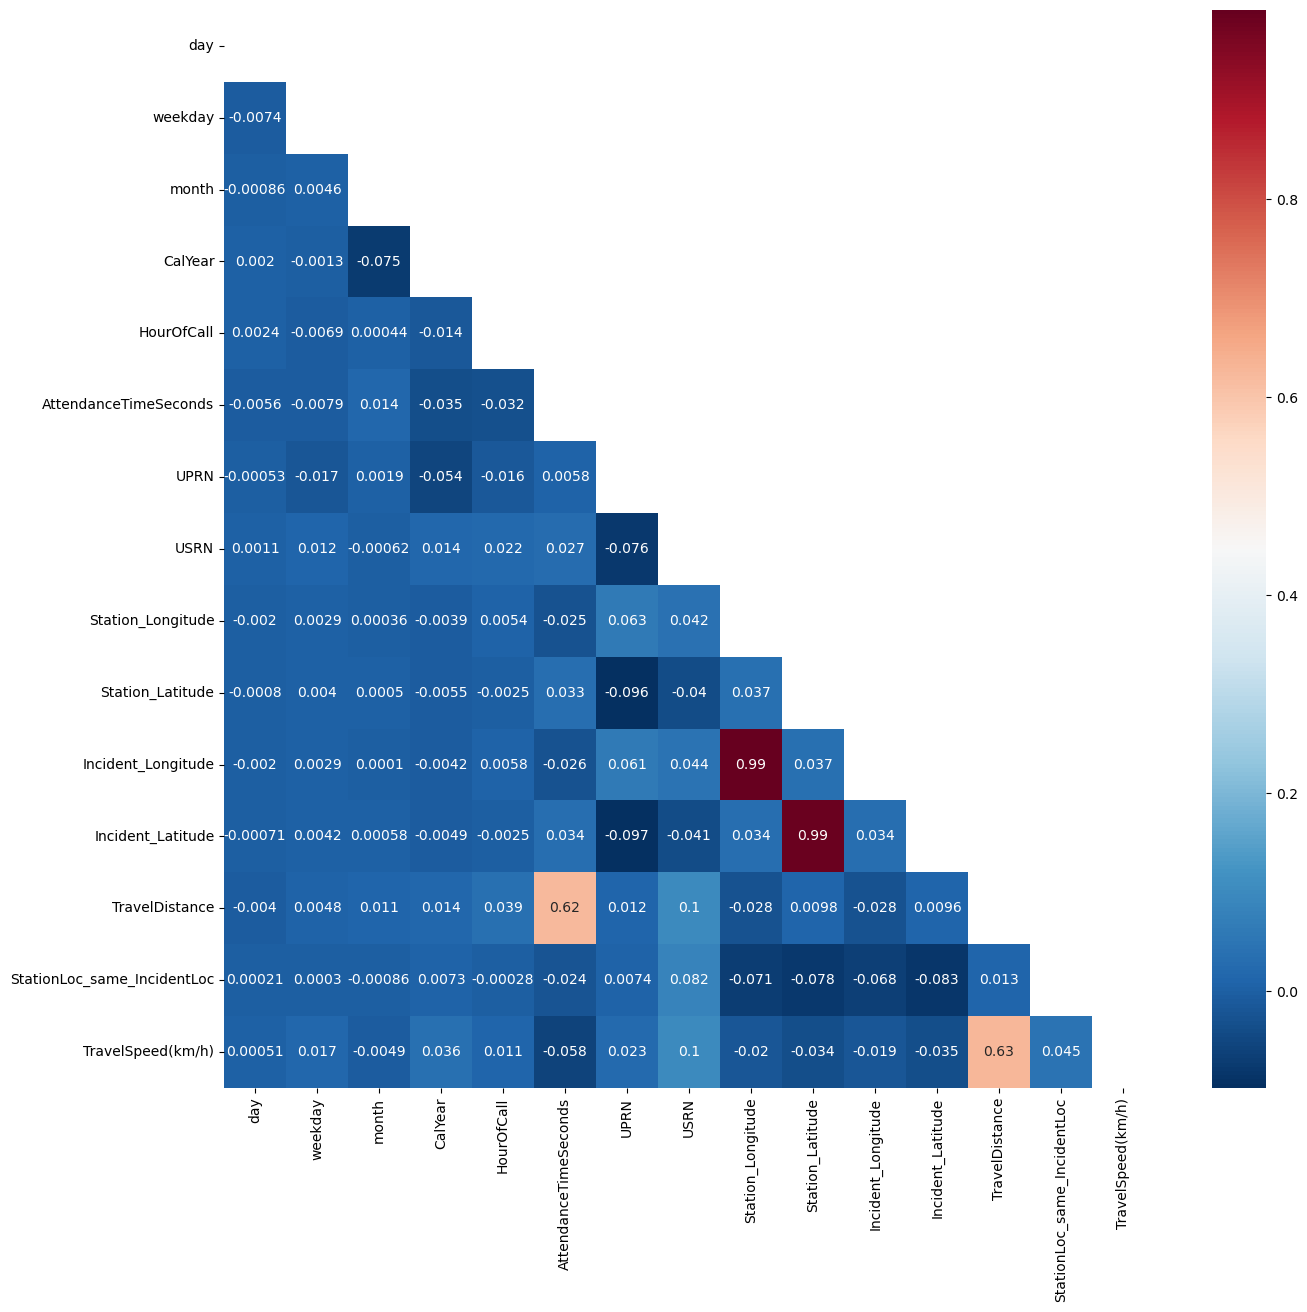

In [5]:
#cleaned_df['new'] = cleaned_df.apply(lambda x: 0 if x['IncidentStationGround'] == x['DeployedFromStation_Name'] else 1, axis=1)

# Calculate the correlation matrix of the cleaned DataFrame
corr = cleaned_df.corr()

# Create an upper triangular matrix to mask the lower triangle in the heatmap
matrix = np.triu(corr)

# Round the correlation values to two decimal places for better readability
rounded_corr_matrix = corr.round(2)

# Set the size of the heatmap figure
plt.figure(figsize=(15, 14))

# Generate the heatmap using seaborn's heatmap function
sns.heatmap(corr, annot=True, cmap='RdBu_r', mask=matrix)

# Show the heatmap
plt.show()


# group

In [14]:
# 4 groups within quantiles
group=cleaned_df.copy()
group['AttendanceTimeSeconds'] = pd.qcut(x=cleaned_df['AttendanceTimeSeconds'], q=4, labels=[0,1,2,3])

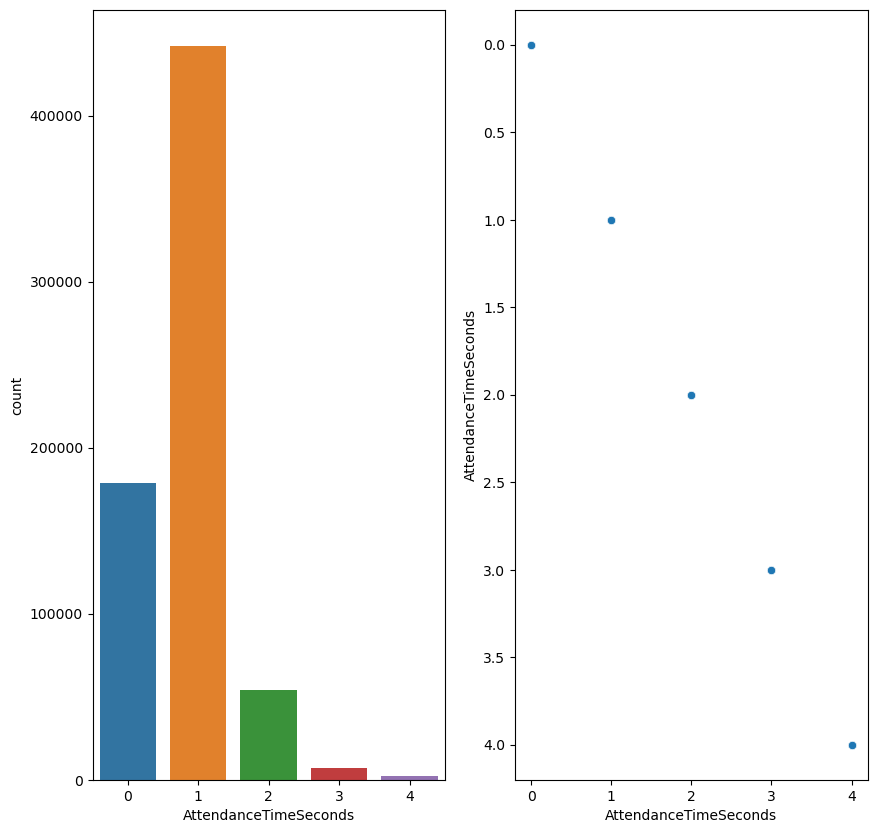

In [6]:
# 5 groups with 240 seconds
group = cleaned_df.copy()
group['AttendanceTimeSeconds'] = pd.cut(x=cleaned_df['AttendanceTimeSeconds'], bins=[0,240,480,720,960,1200], labels=[0,1,2,3,4])

fig, axs = plt.subplots(1,2, figsize=(10,10))
sns.countplot(x='AttendanceTimeSeconds', data=group, ax=axs[0])
sns.scatterplot(x='AttendanceTimeSeconds', y='AttendanceTimeSeconds', data=group, ax=axs[1]);

In [11]:
# 4 groups within quantiles

group=cleaned_df.copy()
group.dropna(inplace=True)
group['AttendanceTimeQuantiles'] = pd.qcut(x=cleaned_df['AttendanceTimeSeconds'], q=4, labels=[0,1,2,3]).astype('int')

# 4 groups with equal seconds
group['AttendanceTimeFiveGroups'] = pd.cut(x=cleaned_df['AttendanceTimeSeconds'], bins=[0,240,480,720,960,1200], labels=[0,1,2,3,4]).astype('int')

from sklearn.cluster import KMeans
cluster_data = group[['AttendanceTimeSeconds']]
# Perform K-means clustering
kmeans = KMeans(n_clusters=5).fit(cluster_data)
# Assign cluster labels to the dataframe
group['Cluster'] = kmeans.labels_

display(group.isna().sum())


C:\Users\User1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Resource_Code                  0
DeployedFromStation_Name       0
DeployedFromLocation           0
IncidentGroup                  0
SpecialServiceType             0
PropertyCategory               0
Postcode_district              0
IncGeo_BoroughName             0
IncGeo_WardNameNew             0
IncidentStationGround          0
day                            0
weekday                        0
month                          0
CalYear                        0
HourOfCall                     0
AttendanceTimeSeconds          0
UPRN                           0
USRN                           0
Station_Longitude              0
Station_Latitude               0
Incident_Longitude             0
Incident_Latitude              0
TravelDistance                 0
StationLoc_same_IncidentLoc    0
TravelSpeed(km/h)              0
AttendanceTimeQuantiles        0
AttendanceTimeFiveGroups       0
Cluster                        0
dtype: int64

# preprocessing

In [12]:
# Make a copy of the original dataframe
df_num = group.copy()

# Columns to drop from the dataframe
columns_to_drop = ['TravelSpeed(km/h)', 'Station_Latitude', 'Station_Longitude', 'Incident_Latitude', 'Incident_Longitude', 
                   'AttendanceTimeSeconds', 'Cluster', 'AttendanceTimeFiveGroups']

# Drop the specified columns from the dataframe
df_num = df_num.drop(columns_to_drop, axis=1)

# Extract categorical column names
cats = df_num.select_dtypes(exclude=np.number).columns.tolist()

# Split the data into training and testing sets based on 'CalYear'
train = df_num[df_num['CalYear'] < 2022]
test = df_num[df_num['CalYear'] >= 2022]

# Separate the target variable ('AttendanceTimeQuantiles') from the features in the training and testing sets
y_train, X_train = train['AttendanceTimeQuantiles'], train.drop(['AttendanceTimeQuantiles'], axis=1)
y_test, X_test = test['AttendanceTimeQuantiles'], test.drop(['AttendanceTimeQuantiles'], axis=1)

# BaseN Encoding for categorical features
for col in cats:
    # Initialize BaseN encoder with base 5
    encoder = ce.BaseNEncoder(base=5)
    
    # Encode the categorical feature for the training set
    data_encoded = encoder.fit_transform(X_train[[col]])
    X_train = pd.concat([X_train, data_encoded], axis=1)
    X_train.drop(col, axis=1, inplace=True)
    
    # Encode the categorical feature for the testing set
    data_encoded_test = encoder.transform(X_test[[col]])
    X_test = pd.concat([X_test, data_encoded_test], axis=1)
    X_test.drop(col, axis=1, inplace=True)

# Standardize the numerical features using StandardScaler
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Print the shapes of the final training and testing sets
print('train:', X_train.shape)
print('test:', X_test.shape)


train: (529291, 37)
test: (134999, 37)


# modeling

### decision tree 

In [13]:
# Import the necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create a Decision Tree classifier with a maximum depth of 19
dt = DecisionTreeClassifier(max_depth=19)

# Fit the classifier on the standardized training data
dt.fit(X_train_std, y_train)

# Predict the target variable on both training and test data
y_pred_dt_test = dt.predict(X_test_std)
y_pred_dt_train = dt.predict(X_train_std)

# Print the accuracy score on the training data
print(f'train score: {dt.score(X_train_std, y_train)}')

# Print the accuracy score on the test data
print(f'test score: {dt.score(X_test_std, y_test)}')

# Generate the classification report, providing precision, recall, f1-score, and support for each class
print(classification_report(y_test, y_pred_dt_test))


train score: 0.750571991588748
test score: 0.4844998851843347
              precision    recall  f1-score   support

           0       0.61      0.63      0.62     34039
           1       0.38      0.40      0.39     33948
           2       0.37      0.37      0.37     33333
           3       0.58      0.54      0.56     33679

    accuracy                           0.48    134999
   macro avg       0.49      0.48      0.48    134999
weighted avg       0.49      0.48      0.49    134999



In [ ]:
####### bis random forest nicht ausführen #########

In [ ]:
tree_param = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]}

grid_dt = GridSearchCV(estimator=dt, param_grid = tree_param, scoring='roc_auc')
grid_dt.fit(X_train_std, y_train)
print(grid_dt.best_params_)

grid_dt_pred_train = grid_dt.predict(X_train_std)
grid_dt_pred_test = grid_dt.predict(X_test_std)

print(f'train score: {grid_dt.score(X_train_std, y_train)}')
print(f'test score: {grid_dt.score(X_test_std, y_test)}')
print(f'train mse: {mean_squared_error(grid_dt_pred_train, y_train)}')
print(f'test mse: {mean_squared_error(grid_dt_pred_test, y_test)}')

print(f'train mae: {mean_absolute_error(grid_dt_pred_train, y_train)}') # print mse on train data
print(f'test mae: {mean_absolute_error(grid_dt_pred_test, y_test)}')# print mse on test data

print(classification_report(y_test, grid_dt_pred_test))

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 30))
plot_tree(dt, feature_names=X_train.columns.tolist(),
          filled=True)  # proportion=True
plt.show()

In [ ]:
feat_importances = pd.Series(
    dt.feature_importances_, index=X_train.columns)
feat_importances.nlargest(3).plot(kind='barh')
plt.show()

In [ ]:
import shap
explainer = shap.TreeExplainer(
    dt, data=X_train_std[:10], model_output="probability")
shap_values = explainer.shap_values(X_test_std)

print('Expected Value:', explainer.expected_value)

pd.DataFrame(shap_values).head()

In [51]:
from imblearn.over_sampling import RandomOverSampler

X_ru, y_ru = RandomOverSampler().fit_resample(X_train_std, y_train)# Applying RandomOverSampler to the training data 

###  random forest classifier

In [14]:
# Create a RandomForestClassifier instance
rfc = RandomForestClassifier()

# Fit the model to the standardized training data
rfc.fit(X_train_std, y_train)

# Make predictions on the training and test data
y_pred_rfc_train = rfc.predict(X_train_std)
y_pred_rfc_test = rfc.predict(X_test_std)

# Print the accuracy scores on the training and test data
print(f'train score: {rfc.score(X_train_std, y_train)}')  
print(f'test score: {rfc.score(X_test_std, y_test)}')

# Calculate and print the mean squared error on the training and test data
print(f'train MSE: {mean_squared_error(y_pred_rfc_train, y_train)}') 
print(f'test MSE: {mean_squared_error(y_pred_rfc_test, y_test)}') 

# Calculate and print the mean absolute error on the training and test data
print(f'train MAE: {mean_absolute_error(y_pred_rfc_train, y_train)}') 
print(f'test MAE: {mean_absolute_error(y_pred_rfc_test, y_test)}') 

# Display the confusion matrix and print the classification report for the test data
display(pd.crosstab(y_pred_rfc_test, y_test))
print(classification_report(y_test, y_pred_rfc_test))


train score: 0.9991120196640412
test score: 0.5596782198386655
train mse: 0.0016248150828183363
test mse: 0.7720723857213757
train mae: 0.0011146987196079283
test mae: 0.541433640249187


AttendanceTimeQuantiles,0,1,2,3
row_0,,,,
0,24872,8285,2727,1431
1,7095,15227,8409,3032
2,1585,7966,13207,6966
3,487,2470,8990,22250


              precision    recall  f1-score   support

           0       0.67      0.73      0.70     34039
           1       0.45      0.45      0.45     33948
           2       0.44      0.40      0.42     33333
           3       0.65      0.66      0.66     33679

    accuracy                           0.56    134999
   macro avg       0.55      0.56      0.56    134999
weighted avg       0.55      0.56      0.56    134999



In [15]:
display(pd.crosstab(y_pred_rfc_test, y_test), normalize=True)

TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'normalize'

### KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_std, y_train)

y_pred_knn_test = knn.predict(X_test_std)
y_pred_knn_train = knn.predict(X_train_std)

print(f'train score: { knn.score(X_train_std, y_train)}')  # print score on train data
print(f'test score: {knn.score(X_test_std, y_test)}') # print score on test data
print(f'train mse: {mean_squared_error(y_pred_knn_train, y_train)}') # print mse on train data
print(f'test mse: {mean_squared_error(y_pred_knn_test, y_test)}') # print mse on test data

display(pd.crosstab(y_pred_rfc_test, y_test))
print(classification_report(y_test, y_pred_rfc_test))

train score: 0.7844210462675542
test score: 0.6778272431647642
train mse: 0.29542350049405713
test mse: 0.38569174586478416


AttendanceTimeFiveGroups,0,1,2,3,4
row_0,,,,,
0,22557,7650,283,70,32
1,12929,78563,8057,876,254
2,1,1026,2315,331,50
3,0,1,2,0,1
4,0,0,0,1,0


              precision    recall  f1-score   support

           0       0.74      0.64      0.68     35487
           1       0.78      0.90      0.84     87240
           2       0.62      0.22      0.32     10657
           3       0.00      0.00      0.00      1278
           4       0.00      0.00      0.00       337

    accuracy                           0.77    134999
   macro avg       0.43      0.35      0.37    134999
weighted avg       0.75      0.77      0.75    134999



# ab hier nicht mehr ausführen 

In [57]:
# Defining the range of hyperparameter 'n_neighbors' for Grid Search
knn_param = {'n_neighbors': range(1, 100)}

# Perform Grid Search to find the best hyperparameter value
grid_knn = GridSearchCV(estimator=knn, param_grid=knn_param)
grid_knn.fit(X_train_std, y_train)

# Print the best hyperparameter value found by Grid Search
print("Best Hyperparameter:", grid_knn.best_params_)

# Predict the target variable using the best model obtained after Grid Search
grid_knn_pred_test = grid_knn.predict(X_test_std)

# Display a cross-tabulation (confusion matrix) of predicted vs. actual labels
display(pd.crosstab(grid_knn_pred_test, y_test))

# Generate and display a classification report to assess model performance
# against the test set
print("Classification Report:")
print(classification_report(y_test, grid_knn_pred_test))

{'n_neighbors': 29}


AttendanceTimeSeconds,0,1,2,3,4
row_0,,,,,
0,1585,1027,41,9,0
1,2435,7970,1096,149,41
2,1,7,5,3,2


              precision    recall  f1-score   support

           0       0.60      0.39      0.47      4021
           1       0.68      0.89      0.77      9004
           2       0.28      0.00      0.01      1142
           3       0.00      0.00      0.00       161
           4       0.00      0.00      0.00        43

    accuracy                           0.67     14371
   macro avg       0.31      0.26      0.25     14371
weighted avg       0.62      0.67      0.62     14371



C:\Users\User1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bagging classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier()
bc.fit(X_train_std, y_train)

bc_pred_train = bc.predict(X_train_std) # predict y_train
bc_pred_test = bc.predict(X_test_std)  # predict y_test


print(bc.oob_score_)
print(f'train score: {bc.score(X_train_std, y_train)}')  # print score on train data
print(f'test score: {bc.score(X_test_std, y_test)}') # print score on test data
print(f'train mse: {mean_squared_error(bc_pred_train, y_train)}') # print mse on train data
print(f'test mse: {mean_squared_error(bc_pred_test, y_test)}') # print mse on test data
print(f'train mae: {mean_absolute_error(bc_pred_train, y_train)}') # print mse on train data
print(f'test mae: {mean_absolute_error(bc_pred_test, y_test)}') # print mse on test data

# AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier

ac = AdaBoostClassifier(base_estimator=rfc, n_estimators=400)
ac.fit(X_train_std, y_train)

new = ac.predict(X_train_std) # predict y_train
new_test = ac.predict(X_test_std)  # predict y_test

print(f'train score: {ac.score(X_train_std, y_train)}')  # print score on train data
print(f'test score: {ac.score(X_test_std, y_test)}') # print score on test data
print(f'train mse: {mean_squared_error(new, y_train)}') # print mse on train data
print(f'test mse: {mean_squared_error(new_test, y_test)}') # print mse on test data
print(f'train mae: {mean_absolute_error(new, y_train)}') # print mse on train data
print(f'test mae: {mean_absolute_error(new_test, y_test)}') # print mse on test data

C:\Users\User1\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


KeyboardInterrupt: 

# VotingClassifier

In [69]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

vclf = VotingClassifier(estimators=[("dt",dt), ("rfc",rfc), ('knn', knn)], voting="soft")
vclf.fit(X_train_std, y_train)

#vclf_pred_train = vclf.predict(X_train_std) # predict y_train
vclf_pred_test = vclf.predict(X_test_std)  # predict y_test


display(pd.crosstab(vclf_pred_test, y_test))
print(classification_report(y_test, vclf_pred_test))

MemoryError: could not allocate 29360128 bytes

In [ ]:
sclf = StackingClassifier(estimators=[("dt",dt), ("rfc",rfc), ('knn', knn)])
sclf.fit(X_train_std, y_train)

#vclf_pred_train = vclf.predict(X_train_std) # predict y_train
sclf_pred_test = sclf.predict(X_test_std)  # predict y_test


display(pd.crosstab(sclf_pred_test, y_test))
print(classification_report(y_test, sclf_pred_test))

**SPLITTING OF DATA**

In [ ]:
cleaned_df['AttendanceTime'] = pd.qcut(cleaned_df['AttendanceTimeSeconds'], q=2, labels=['Q1', 'Q2'])

data = cleaned_df.drop(['AttendanceTimeSeconds','AttendanceTime'], axis =1)
target = cleaned_df['AttendanceTime']



X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

**VARIANCE THRESHOLD AND NORMALIZATION**

In [ ]:
# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)

from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
X_train= scaler.fit_transform(X_train)

# Transform your test data using the fitted scaler
X_test= scaler.transform(X_test)

**SVM with NYSTROEM and SGDClassifier** 

In [ ]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

# Create a Nystroem transformer object
nystroem = Nystroem(kernel='rbf')

# Approximate the kernel matrix
X_train_approx = nystroem.fit_transform(X_train)
X_test_approx = nystroem.transform(X_test)

# Create an SGDClassifier object
svm = SGDClassifier(loss='hinge')

# Fit the classifier to the approximated training data
svm.partial_fit(X_train_approx, y_train, classes=np.unique(y_train))

# Predict the target variable for the approximated test data
y_pred = svm.predict(X_test_approx)

print('svm test score:',svm.score(X_test_approx,y_test)) #print test score 
print('svm train score:',svm.score(X_train_approx,y_train))

**classification report,confusion matrix, roc auc score**

In [ ]:
print(classification_report(y_test, y_pred,zero_division=1))
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_numeric = np.where(y_pred == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_numeric))#print roc auc score

**PLOTTING OF LEARNING CURVE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

#defining a function
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (SGDClassifier)"
cv = 5  # Cross-validation folds

# Create an instance of the SGDClassifier
svm = SGDClassifier(loss='hinge')

# Plot the learning curve
plot_learning_curve(svm, title, X_train_approx, y_train, cv=cv)
plt.show()


**Model Robustness Test: Sensitivity Analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to add perturbations to the data
def add_perturbations(X, magnitude=0.1):
    X_perturbed = X + np.random.normal(0, magnitude, X.shape)
    return X_perturbed

# Define the magnitude of the perturbations and the number of iterations
perturbation_magnitude = 0.1
num_iterations = 100

# Lists to store accuracy scores for each iteration
accuracies = []

# Perform multiple iterations of perturbations
for i in range(num_iterations):
    # Generate perturbed test data
    X_test_perturbed = add_perturbations(X_test_approx, magnitude=perturbation_magnitude)
    
    # Predict the target variable for the perturbed test data
    y_pred_perturbed = svm.predict(X_test_perturbed)
    
    # Calculate the accuracy for this iteration and store it
    accuracy_perturbed = accuracy_score(y_test, y_pred_perturbed)
    accuracies.append(accuracy_perturbed)

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)

# Display the results on a graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), accuracies, marker='o', linestyle='-', color='b')
plt.axhline(y=average_accuracy, color='r', linestyle='--', label='Average Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Robustness Test: Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





**calibration curve**

In [ ]:
from sklearn.calibration import calibration_curve
y_scores = svm.decision_function(X_test_approx)

# Convert decision function scores to probabilities using Platt scaling
# Note: For SGDClassifier, probability=True is not supported during partial_fit,
# so we'll use Platt scaling to convert decision function scores to probabilities.
def platt_scaling(decision_scores):
    return 1 / (1 + np.exp(-decision_scores))

y_pred_prob = platt_scaling(y_scores)

# Assuming y_test contains the actual binary outcomes (0 or 1)
prob_true, prob_pred = calibration_curve(y_test_numeric, y_pred_prob, n_bins=10)

# Create a calibration plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')

plt.tight_layout()
plt.show();

#the points deviate significantly from the diagonal line, the model may suffer from calibration issues,
#and the predicted probabilities might need to be recalibrated.


**RandomizedSearchCV**

In [ ]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution to sample from
param_dist = {
    'alpha': stats.loguniform(1e-6, 1e-2),
    'penalty': ['l1', 'l2'],
    'max_iter': stats.randint(100, 5000),
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=4, random_state=42)
random_search.fit(X_train_approx, y_train)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_svm = random_search.best_estimator_

# Predict the target variable for the approximated test data
y_pred_test = best_svm.predict(X_test_approx)
y_pred_train = best_svm.predict(X_train_approx)
# Evaluate the model's accuracy

print("Best Hyperparameters:", best_params)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("SVM Train Accuracy:", accuracy_score(y_train, y_pred_train))
classi_rep = classification_report(y_test, y_pred_test,zero_division=1)
print(classi_rep)

from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_numeric = np.where(y_pred_test == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_test))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_numeric))

**(ROC) Curve as Scatter Plot**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp


# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_numeric, y_pred_numeric)


# Calculate the ROC curve and confidence intervals using StratifiedKFold
cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for i, (train, test) in enumerate(cv.split(X_test_approx, y_test_numeric)):
    # Fit the model on the training data
    random_search.fit(X_test_approx[train], y_test_numeric[train])

    # Get the decision scores (not probabilities) for the test set
    decision_scores = random_search.decision_function(X_test_approx[test])

    # Compute ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test_numeric[test], decision_scores)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)  # Ensure to import the `auc` function from sklearn.metrics
    aucs.append(roc_auc)

    # Plot the current fold's ROC curve as scatter plot
    plt.scatter(fpr, tpr, s=80, label='ROC Fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

# Plot the mean ROC curve and confidence intervals
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label='Mean ROC (AUC = %0.2f)' % mean_auc)

# Shade the area between the confidence intervals
std_auc = np.std(aucs)
tpr_upper = np.minimum(mean_tpr + std_auc, 1)
tpr_lower = mean_tpr - std_auc
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.2, label='Confidence Interval')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve as Scatter Plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();


**BAGGING**

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Create a BaggingClassifier with the SGDClassifier as the base estimator
bagging_svm = BaggingClassifier(base_estimator=svm, n_estimators=20, random_state=42)

# Fit the BaggingClassifier to the approximated training data
bagging_svm.fit(X_train_approx, y_train)

# Predict the target variable for the approximated test data using Bagging
y_pred_trainbag = bagging_svm.predict(X_test_approx)
y_pred_testbag = bagging_svm.predict(X_test_approx)

print("Bagging svm Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Bagging svm Train Accuracy:", accuracy_score(y_train, y_pred_train))

from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_numeric = np.where(y_pred_testbag == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_testbag))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_numeric))

**BOOSTING

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Create an AdaBoostClassifier with the SGDClassifier as the base estimator and algorithm='SAMME'
adaboost_svm = AdaBoostClassifier(base_estimator=svm, n_estimators=50, random_state=42, algorithm='SAMME')

# Fit the AdaBoostClassifier to the approximated training data
adaboost_svm.fit(X_train_approx, y_train)

# Predict the target variable for the approximated test data using AdaBoost
y_pred_test_adaboost = adaboost_svm.predict(X_test_approx)
y_pred_train_adaboost = adaboost_svm.predict(X_train_approx)

print("Bagging svm Test Accuracy:", accuracy_score(y_test, y_pred_test_adaboost))
print("Bagging svm Train Accuracy:", accuracy_score(y_train, y_pred_train_adaboost))

**KNN KNEIGHBORSCLASSIFIER **

In [ ]:
cleaned_df['AttendanceTime'] = pd.qcut(cleaned_df['AttendanceTimeSeconds'], q=2, labels=['Q1', 'Q2'])
data_knn = cleaned_df.drop(['AttendanceTimeSeconds','AttendanceTime'], axis =1)
target_knn = cleaned_df['AttendanceTime']


X_train, X_test, y_train, y_test = train_test_split(data_knn, target_knn, test_size=0.2, random_state=42)

# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)




# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




**PCA

In [ ]:
# PCA
pca = PCA(n_components=10)  

# Apply PCA on the train dataset
X_train = pca.fit_transform(X_train)

# Apply PCA on the test dataset
X_test = pca.transform(X_test)


knn = KNeighborsClassifier()  

# Fit the KNN model on the train dataset
knn.fit(X_train, y_train)
print('knn test score:',knn.score(X_test, y_test))
print('knn train score:',knn.score(X_train, y_train))

**ROC AUC SCORE**

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_knnnumeric = np.where(y_pred_knn == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_knn))#CONFUSION MATRIX
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_knnnumeric))#roc auc score
classi_rep = classification_report(y_test, y_pred_knn)#classification report
print(classi_rep)

**COHEN KAPPA SCORE**

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Calculate the predicted labels for both train and test datasets
y_pred_knntrain = knn.predict(X_train)
 

# Calculate Cohen's Kappa for train and test datasets
kappa_train = cohen_kappa_score(y_train, y_pred_knntrain)
kappa_test = cohen_kappa_score(y_test, y_pred_knn)

# Print the results
print("Cohen's Kappa - Train:", kappa_train)
print("Cohen's Kappa - Test:", kappa_test)

**BAGGING**

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging_knn = BaggingClassifier(base_estimator=knn, n_estimators=10, random_state=42)

# Fit the BaggingClassifier to the data
bagging_knn.fit(X_train, y_train)

# Evaluate the bagging_knn model
print('Bagging KNN Test Score:', bagging_knn.score(X_test, y_test))
print('Bagging KNN Train Score:', bagging_knn.score(X_train, y_train))